In [1]:
import numpy as np

from src.gpytorch_model import ExactGPModel
import gpytorch
import torch


kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel(lengthscale=0.75, lengthscale_constraint=gpytorch.constraints.Interval(0.5, 1), alpha=50, alpha_constraint=gpytorch.constraints.Interval(5, 100)))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# init model for state dict loading
model = ExactGPModel(None, None, None, None,likelihood, kernel, 100, early_stopping_patience=5)

model.load_state_dict(torch.load("output/gpytorch_models/1.3645.pth"))

<All keys matched successfully>

In [2]:
from main import read_tristans_file
import matplotlib.pyplot as plt

centroids = read_tristans_file("data/centroids.txt")
centroids[0:5]

array([[12.42079905, 51.33769676],
       [12.37135549, 51.33424684],
       [12.37135549, 51.33424684],
       [12.49950692, 51.3481583 ],
       [12.37135549, 51.33424684]])

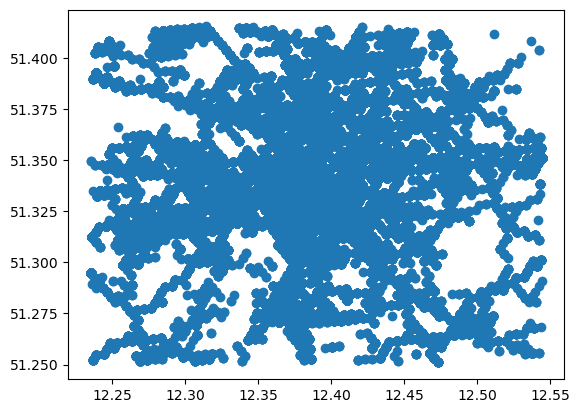

In [3]:
%matplotlib inline
plt.scatter(centroids[:,0], centroids[:,1])
plt.show()

In [4]:
mu_lat, mu_long = centroids.mean(axis=0)
sig_lat, sig_long = centroids.std(axis=0)
mu_lat, sig_lat, mu_long, sig_long

(12.382681510239907,
 0.06184446269806745,
 51.33933159139332,
 0.03211982509844967)

In [5]:
centroids_std = (centroids-centroids.mean(axis=0))/ centroids.std(axis=0)
centroids_std

array([[ 0.61634518, -0.05089775],
       [-0.18313715, -0.15830561],
       [-0.18313715, -0.15830561],
       ...,
       [-1.33115727, -0.54786604],
       [-1.33115727, -0.54786604],
       [-0.21241048, -0.39641538]])

In [6]:
model.eval()
standardized_preds = model(torch.tensor(centroids_std, requires_grad=False)).mean.detach().numpy()

In [7]:
import pandas as pd
import numpy as np
all_data = pd.read_csv("data/Prob_ml.csv")
out_mean = all_data["rsrp"].mean()
out_std = all_data["rsrp"].std()

unstandardized_preds = (standardized_preds * out_std) + out_mean

pred_df =pd.DataFrame(np.array([centroids[:, 0], centroids[:, 1], unstandardized_preds]).T, columns=["lat", "long", "rsrp_hat"])
pred_df.head()

/tmp/ipykernel_36853/2171326708.py:3: DtypeWarning: Columns (1,2,3,10,11,12,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("data/Prob_ml.csv")


,lat,long,rsrp_hat
0,12.420799,51.337697,-99.705811
1,12.371355,51.334247,-99.705811
2,12.371355,51.334247,-99.705811
3,12.499507,51.348158,-99.705811
4,12.371355,51.334247,-99.705811


In [11]:
import plotly.express as ex

fig = ex.scatter_3d(pred_df.sample(1000), x="lat", y="long", z="rsrp_hat", color="rsrp_hat")
fig.show()